**Линейные модели, SVM и деревья решений.**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline
sns.set(style="ticks")

In [4]:
df = pd.read_csv('medical_insurance.csv', sep=",")

In [5]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [4]:
df.shape

(2772, 7)

In [5]:
# ищем пропуски
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
categorical_cols=df.select_dtypes(include=object).columns.to_list()
categorical_cols

['sex', 'smoker', 'region']

In [7]:
for cat in categorical_cols:
    print(f"column -- {cat}: {df[cat].unique()}")

column -- sex: ['female' 'male']
column -- smoker: ['yes' 'no']
column -- region: ['southwest' 'southeast' 'northwest' 'northeast']


In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
for cat in categorical_cols:
    le = LabelEncoder()
    df[cat] = le.fit_transform(df[cat])

In [11]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
2767,47,0,45.320,1,0,2,8569.86180
2768,21,0,34.600,0,0,3,2020.17700
2769,19,1,26.030,1,1,1,16450.89470
2770,23,1,18.715,0,0,1,21595.38229


In [12]:
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [13]:
for cat in categorical_cols:
    print(f"column -- {cat}: {df[cat].unique()}")

column -- sex: [0 1]
column -- smoker: [1 0]
column -- region: [3 2 1 0]


In [10]:
X = df.drop('charges', axis=1)  # Замените 'целевая_переменная' на название вашей целевой переменной
y = df['charges']

In [11]:
# Формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<Axes: >

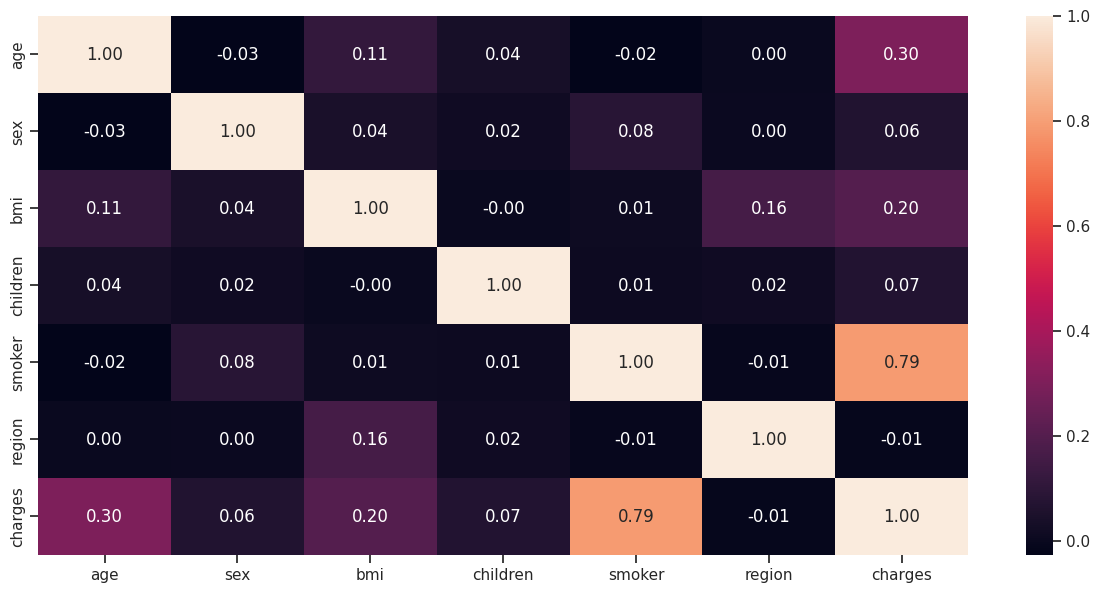

In [16]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
# Scaling the features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Converting the scaled arrays into DataFrames
X_train = pd.DataFrame(X_train_scale, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scale, columns=X_test.columns)

In [14]:
X_train.shape

(2217, 6)

In [15]:
X_test.shape

(555, 6)

In [25]:
def create_df(data,models, cols):
    index = []
    for model in models:
        model_name = type(model).__name__
        if model_name in index:
            model_name = str(type(model).__name__) + '_hyp'       
        index.append(model_name)

    df = pd.DataFrame(data = data,
                     index = index)
    df.rename(columns=dict(zip(df.columns, cols)), inplace=True)
    return df

def training(models, X=X_train, y=y_train):
    metric = {}
    train_model = []
    mses =[]
    maes =[]
    r2s =[]
    index =[]
    for model in models:
        #score = []  # Initialize score for each model
        model.fit(X, y)
        train_model.append(model)
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        mses.append(mse)
        mae = mean_absolute_error(y, y_pred)
        maes.append(mae)
        r2 = r2_score(y, y_pred)*100
        r2s.append(r2)
        #score.extend([mse, mae, r2])  # Use extend to add multiple elements to score
        
    cols=['train_mse', 'train_mae', 'train_r2']
    metric['mse'] = mses
    metric['mae'] = maes
    metric['r2'] = r2s
    metric_df = create_df(data=metric,models= train_model, cols = cols)
    return metric_df, train_model

def testing(models,X = X_test, y = y_test):
    mses =[]
    maes =[]
    r2s =[]
    index =[]
    metric = {}
    for model in models:
        #score = []  # Initialize score for each model
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        mses.append(mse)
        mae = mean_absolute_error(y, y_pred)
        maes.append(mae)
        r2 = r2_score(y, y_pred)*100
        r2s.append(r2)
        #score.extend([mse, mae, r2])  # Use extend to add multiple elements to score
    metric['mse'] = mses
    metric['mae'] = maes
    metric['re'] = r2s
    cols=['test_mse', 'test_mae', 'test_r2']
    metric_df = create_df(data=metric,models= models, cols=cols)
    return metric_df

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
base_model = DecisionTreeRegressor(max_depth=3)
rf = RandomForestRegressor(n_estimators=5, oob_score=True, random_state=42)
etr = ExtraTreesRegressor(n_estimators=5, oob_score=True, random_state=42, bootstrap=True)
abr = AdaBoostRegressor(base_estimator=base_model, n_estimators=5, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

In [23]:
pd.options.display.float_format = '{:.3f}'.format
models = [rf, etr, abr, gbr]
training_df, train_models = training(models)

training_df

/home/sofi_flin/Documents/ml_spring_23/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/sofi_flin/Documents/ml_spring_23/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/sofi_flin/Documents/ml_spring_23/.venv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,train_mse,train_mae,train_r2
RandomForestRegressor,2179569.176,498.927,98.508
ExtraTreesRegressor,2118513.707,493.815,98.550
AdaBoostRegressor,22643419.217,3679.647,84.500
GradientBoostingRegressor,10957994.903,1769.074,92.499


In [24]:
test_df = testing(train_models)

test_df

,test_mse,test_mae,test_r2
RandomForestRegressor,9444619.196,1343.661,93.846
ExtraTreesRegressor,10098510.710,1416.470,93.420
AdaBoostRegressor,25702298.929,3785.518,83.254
GradientBoostingRegressor,16573386.339,2119.189,89.202


In [25]:
param_range = np.arange(5, 120, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115])}]

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

gs = GridSearchCV(RandomForestRegressor(random_state=42), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115])}],
             return_train_score=True, scoring='r2')

In [27]:
reg = gs.best_estimator_
reg

RandomForestRegressor(n_estimators=115, random_state=42)

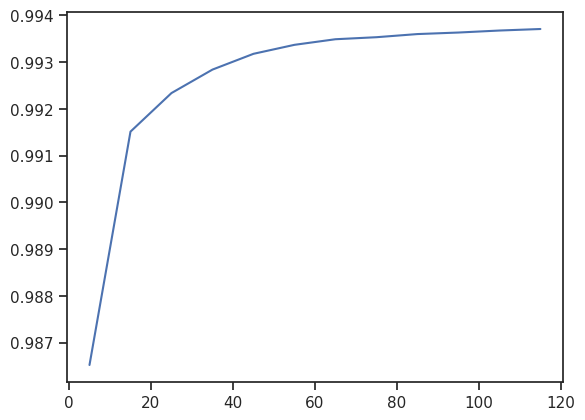

In [28]:
import matplotlib.pyplot as plt

plt.plot(param_range, gs.cv_results_["mean_train_score"]);

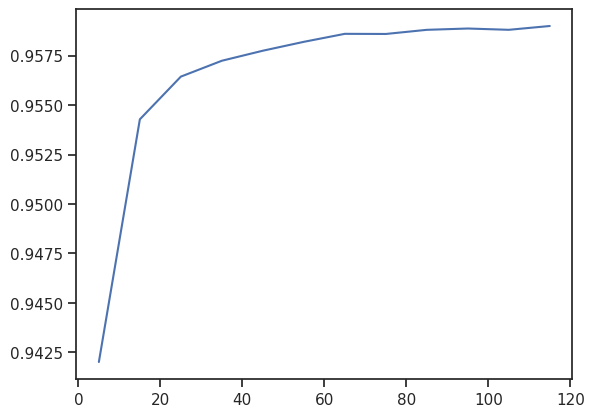

In [29]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

gs_e = GridSearchCV(ExtraTreesRegressor(random_state=42), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs_e.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115])}],
             return_train_score=True, scoring='r2')

In [31]:
reg_e = gs_e.best_estimator_
reg_e

ExtraTreesRegressor(n_estimators=55, random_state=42)

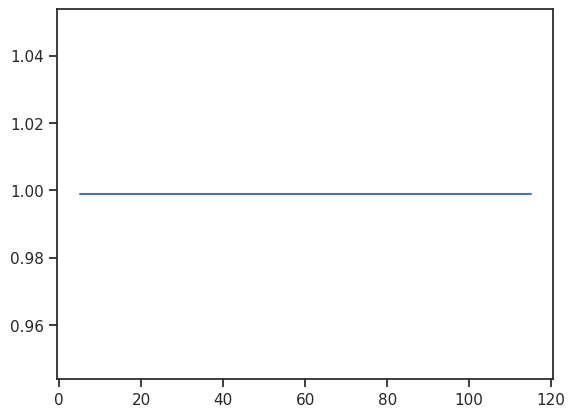

In [32]:
import matplotlib.pyplot as plt

plt.plot(param_range, gs_e.cv_results_["mean_train_score"]);

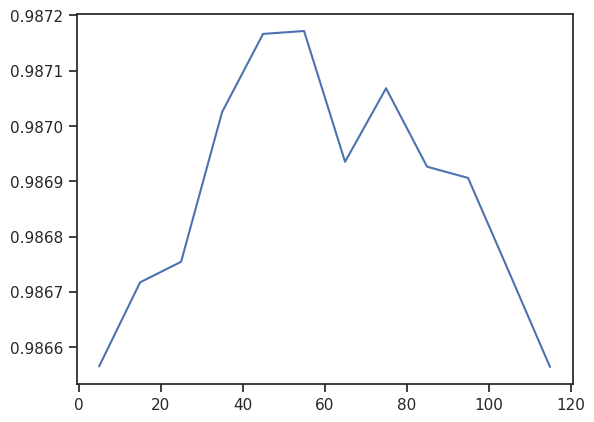

In [33]:
plt.plot(param_range, gs_e.cv_results_["mean_test_score"]);

In [34]:
param_range_a = np.arange(1, 25, 1)
tuned_parameters_a = [{'n_estimators': param_range_a}]
tuned_parameters_a

[{'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24])}]

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

gs_a = GridSearchCV(AdaBoostRegressor(random_state=42), tuned_parameters_a,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs_a.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}],
             return_train_score=True, scoring='r2')

In [36]:
reg_a = gs_a.best_estimator_
reg_a

AdaBoostRegressor(n_estimators=1, random_state=42)

In [37]:
param_range_g = np.arange(5, 250, 10)
tuned_parameters_g = [{'n_estimators': param_range_g}]
tuned_parameters_g

[{'n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
         135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245])}]

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

gs_b = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, random_state=42), tuned_parameters_g,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs_b.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245])}],
             return_train_score=True, scoring='r2')

In [39]:
reg_b = gs_b.best_estimator_
reg_b

GradientBoostingRegressor(n_estimators=245, random_state=42)

In [40]:
X.shape

(2772, 6)

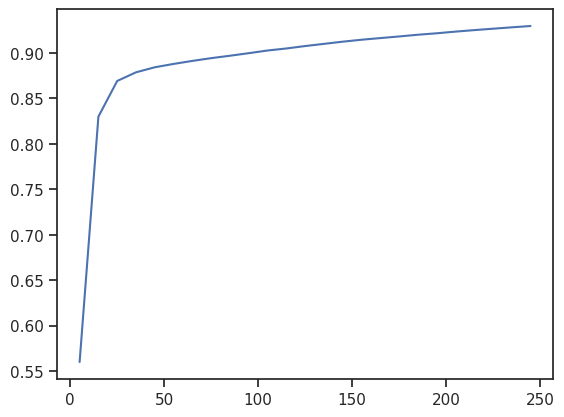

In [41]:
import matplotlib.pyplot as plt

plt.plot(param_range_g, gs_b.cv_results_["mean_train_score"]);

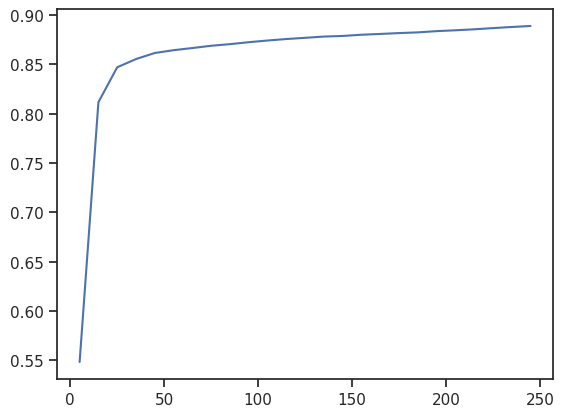

In [42]:
plt.plot(param_range_g, gs_b.cv_results_["mean_test_score"]);

In [43]:
param_range_n_estimators = np.arange(100, 250, 10)
param_range_learning_rate = [0.01, 0.1, 0.5, 1.0]  # Примеры значений learning rate

# Создание словаря с параметрами для перебора
tuned_parameters_gb = [{'n_estimators': param_range_n_estimators, 'learning_rate': param_range_learning_rate}]

# Инициализация GridSearchCV
gs_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), tuned_parameters_gb,
                     cv=ShuffleSplit(n_splits=10), scoring="r2",
                     return_train_score=True, n_jobs=-1)

# Подгонка модели
gs_gb.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.1, 0.5, 1.0],
                          'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240])}],
             return_train_score=True, scoring='r2')

In [44]:
reg_gb = gs_gb.best_estimator_
reg_gb

GradientBoostingRegressor(learning_rate=1.0, n_estimators=240, random_state=42)

In [45]:
pd.options.display.float_format = '{:.3f}'.format
models = [reg, reg_e, reg_a, reg_b, reg_gb]
training_df, train_models = training(models)

training_df

,train_mse,train_mae,train_r2
RandomForestRegressor,1141290.731,483.289,99.219
ExtraTreesRegressor,35245.921,5.639,99.976
AdaBoostRegressor,20793441.873,2863.977,85.766
GradientBoostingRegressor,10200253.396,1709.602,93.017
GradientBoostingRegressor_hyp,1716566.760,800.892,98.825


In [46]:
test_df = testing(train_models)

test_df

,test_mse,test_mae,test_r2
RandomForestRegressor,7471007.678,1301.086,95.132
ExtraTreesRegressor,5728839.250,566.545,96.267
AdaBoostRegressor,25294711.782,3059.547,83.519
GradientBoostingRegressor,15838887.322,2091.539,89.680
GradientBoostingRegressor_hyp,10395176.435,1712.357,93.227


In [47]:
models = [reg, reg_e, reg_a, reg_b, reg_gb]

In [48]:
for model in models:
    model.fit(X_train,y_train)
    print(f"train model -- {model}:  {model.score(X_train,y_train)}")
    print(f"test model -- {model}:  {model.score(X_test,y_test)}")

train model -- RandomForestRegressor(n_estimators=115, random_state=42):  0.9921873783061863
test model -- RandomForestRegressor(n_estimators=115, random_state=42):  0.9513229014530228
train model -- ExtraTreesRegressor(n_estimators=55, random_state=42):  0.9997587266398212
test model -- ExtraTreesRegressor(n_estimators=55, random_state=42):  0.9626739410818484
train model -- AdaBoostRegressor(n_estimators=1, random_state=42):  0.8576600242165229
test model -- AdaBoostRegressor(n_estimators=1, random_state=42):  0.8351931585017145
train model -- GradientBoostingRegressor(n_estimators=245, random_state=42):  0.9301749161957314
test model -- GradientBoostingRegressor(n_estimators=245, random_state=42):  0.8968022638566171
train model -- GradientBoostingRegressor(learning_rate=1.0, n_estimators=240, random_state=42):  0.9882493685995819
test model -- GradientBoostingRegressor(learning_rate=1.0, n_estimators=240, random_state=42):  0.9322705785394467


In [49]:
from IPython.display import Image
from io import StringIO
import pydotplus

In [50]:
#!pip install pydotplus

In [51]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [52]:
Image(get_png_tree(dtr, X.columns), width="500")

NameError: name 'dtr' is not defined

In [ ]:
# Обучим дерево на всех признаках boston c ограничением глубины дерева
short_tree = DecisionTreeRegressor(random_state=42, max_depth=3)
short_tree.fit(X_train, y_train)
short_tree

In [ ]:
model = DecisionTreeRegressor(random_state=42, max_depth=13)
model.fit(X_train,y_train)
print(f"train model -- {model}:  {model.score(X_train,y_train)}")
print(f"train model -- {model}:  {model.score(X_test,y_test)}")

In [ ]:
Image(get_png_tree(short_tree, X_train.columns), height='100%')

In [ ]:
sum(short_tree.feature_importances_)

In [ ]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(reg, df)

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(rf, df)

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(reg_e, df)

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(etr, df)

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(reg_a, df)

In [ ]:
tree_regr_fl, tree_regr_fd = draw_feature_importances(abr, df)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def val_metrics(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    mae = mean_absolute_error(test_y, y_pred)
    r2 = r2_score(test_y, y_pred)
    print(model)
    print('MAE={}'.format(mae))
    print('R2 Score={}'.format(r2))
    print('==========================')

# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(n_estimators=105, random_state=42)
]:
    val_metrics(model, X_train, y_train, X_test, y_test)


In [21]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

In [ ]:
#!pip install heamy


In [1]:
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline

In [ ]:
#r2_score

In [18]:
dataset = Dataset(X_train, y_train, X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression,name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 160},name='rf')
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1124.387530842505, 1018.0220808429318, 1483.5909300570704, 1317.189675307823, 1304.2271857758665, 1317.257076485985, 1478.212027918883, 1272.8253441633394, 1103.031788473896, 1407.4585812614853]
Mean accuracy: 1282.6202221129786
Standard Deviation: 149.82967716706878
Variance: 22448.93215998805
Metric: mean_absolute_error
Folds accuracy: [955.1906343140078, 741.8266014153139, 1334.9387000783338, 1323.9708083833787, 979.1082087383332, 1269.2796022903146, 1080.683032645044, 1048.7995623370578, 973.2470505514042, 1092.0510241507695]
Mean accuracy: 1079.9095224903956
Standard Deviation: 176.9110833674665
Variance: 31297.531418250677
Metric: mean_absolute_error
Folds accuracy: [1089.5046705740458, 947.0488158281471, 1420.1478646304327, 1364.6115039534654, 1142.785642131949, 1298.5074708630336, 1147.9895735806733, 1143.6525616906526, 1074.6941687369724, 1310.3205427409]
Mean accuracy: 1193.9262814730273
Standard Deviation: 140.75373696218537
Varia

In [19]:
dataset = Dataset(X_train, y_train, X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression,name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 160},name='rf')
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=r2_score)
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=r2_score)

# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=r2_score)

# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=r2_score)

Metric: r2_score
Folds accuracy: [0.9604155834396174, 0.9676783124950149, 0.9143296216328749, 0.9103283633184968, 0.9062750691257013, 0.9046892401277392, 0.9013266179105077, 0.9310084850393554, 0.9364865736895556, 0.9057589689509976]
Mean accuracy: 0.923829683572986
Standard Deviation: 0.022919334557578944
Variance: 0.0005252958965622324
Metric: r2_score
Folds accuracy: [0.95138797499365, 0.9773912871236708, 0.9223681093091471, 0.8994528281296649, 0.931307679439366, 0.8887400560499181, 0.9325782332837739, 0.930091929662296, 0.9407304192542247, 0.9227460307492747]
Mean accuracy: 0.9296794547994987
Standard Deviation: 0.023605588845811064
Variance: 0.0005572238247574797
Metric: r2_score
Folds accuracy: [0.9630977928143095, 0.9697698899275307, 0.929893193940304, 0.9130782516187702, 0.9321605448835882, 0.9105340558878181, 0.9377084214841552, 0.9483430210608826, 0.9585861697773104, 0.9208689906648586]
Mean accuracy: 0.9384040332059527
Standard Deviation: 0.019842401115734324
Variance: 0.000

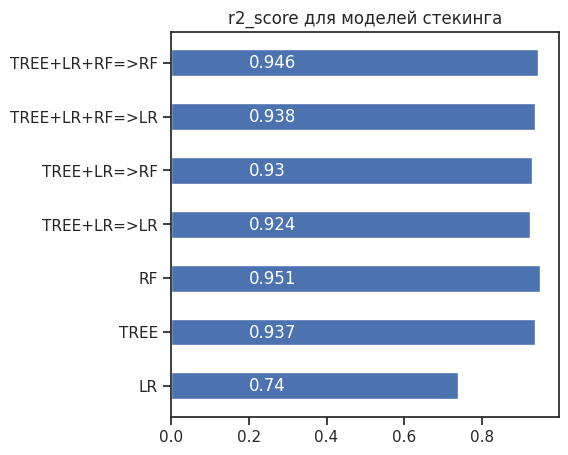

In [22]:
# Результаты
array_labels = ['LR','TREE', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_r2 = [0.7398864322395977, 0.9370575488858102, 0.9512316214891919, 
             0.923829683572986, 0.9296794547994987, 0.9384040332059527, 
             0.9456024060454041]
# Визуализация результатов
vis_models_quality(array_r2, array_labels, 'r2_score для моделей стекинга')

In [23]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(300, 200, 150, 100, 50, 25),  activation='relu', solver='adam', random_state=42)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

In [26]:
pd.options.display.float_format = '{:.3f}'.format
models = [mlp, mlp_model]
training_df, train_models = training(models)

training_df

/home/sofi_flin/Documents/ml_spring_23/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sofi_flin/Documents/ml_spring_23/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,train_mse,train_mae,train_r2
MLPRegressor,16020791.730,2179.870,89.033
MLPRegressor_hyp,32329168.897,3886.080,77.869


In [27]:
test_df = testing(train_models)

test_df

,test_mse,test_mae,test_r2
MLPRegressor,21596791.958,2505.951,85.929
MLPRegressor_hyp,36640353.847,3996.691,76.127


In [28]:
from gmdhpy import gmdh

In [29]:
import gmdh

In [ ]:
#!pip install gmdh

In [ ]:
#!pip install gmdhpy

In [30]:
laptop_x_train, laptop_x_test, laptop_y_train, laptop_y_test = \
    gmdh.split_data(df.drop(['charges'], axis=1), df['charges'], test_size=0.8)
laptop_scaler = StandardScaler().fit(laptop_x_train)
laptop_x_train = laptop_scaler.transform(laptop_x_train)
laptop_x_test = laptop_scaler.transform(laptop_x_test)
print("train elements:", laptop_x_train.shape[0], "\ntest elements:", laptop_x_test.shape[0])

train elements: 554 
test elements: 2218


In [31]:
def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred, squared=squared)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")


In [33]:
laptop_combi_model = gmdh.Combi()
laptop_combi_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, 
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))
print()
print(laptop_combi_model.get_best_polynomial())
print()
laptop_y_pred_combi = laptop_combi_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_combi)

LEVEL 1  [=========================] 100% :00s] (6 combinations) error=6.87079e+09
LEVEL 2  [=========================] 100% :00s] (15 combinations) error=5.22529e+09
LEVEL 3  [=========================] 100% :00s] (20 combinations) error=4.77224e+09
LEVEL 4  [=========================] 100% :00s] (15 combinations) error=4.76817e+09
LEVEL 5  [=========================] 100% :00s] (6 combinations) error=4.86287e+09

y = 3929.2597*x1 + 1927.5676*x3 + 9429.0544*x5 - 16.6626*x6 + 13415.4701

MAE: 4281.452207884143
MSE: 37361873.09104982
R2: 0.7475026136697335


In [34]:
laptop_mia_model = gmdh.Mia()
laptop_mia_model.fit(laptop_x_train, laptop_y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, k_best=9, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.SYM_REGULARITY), 
                     polynomial_type=gmdh.PolynomialType.LINEAR)
laptop_y_pred_mia = laptop_mia_model.predict(laptop_x_test)
print_metrics(laptop_y_test, laptop_y_pred_mia)

LEVEL 1  [=========================] 100% :00s] (15 combinations) error=2.30706e+1
LEVEL 2  [=========================] 100% :00s] (36 combinations) error=2.09675e+1
LEVEL 3  [=========================] 100% :00s] (36 combinations) error=2.09111e+1
LEVEL 4  [=========================] 100% :00s] (36 combinations) error=2.08961e+1
LEVEL 5  [=========================] 100% :00s] (36 combinations) error=2.08981e+1
MAE: 4255.538959422512
MSE: 36938166.8105884
R2: 0.7503660870327393
